# multimodal (DistilKoBert + MobileNet2)

In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [ ]:
# -- 필요한 데이터 --
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/revised_bungae_df.csv')
df['product_id'] = df['product_id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df['main_cat'] = df['main_cat'].astype(str)
df['mid_cat'] = df['mid_cat'].astype(str)
df.head()

,product_id,product_name,image_url,image_cnt,cat_id,main_cat,mid_cat
0,217365207,경량롱패딩,https://media.bunjang.co.kr/product/217365207_...,3.0,310090050,310,310090
1,175507846,롱패딩 판매합니다,https://media.bunjang.co.kr/product/175507846_...,4.0,310090050,310,310090
2,213094512,피레넥스 여성 화이트 패딩 55판-69,https://media.bunjang.co.kr/product/213094512_...,10.0,310090050,310,310090
3,208884568,보브 다운패딩,https://media.bunjang.co.kr/product/208884568_...,2.0,310090050,310,310090
4,164395818,에이글 코트타입 구스 자켓 L사이즈,https://media.bunjang.co.kr/product/164395818_...,5.0,310090050,310,310090


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from PIL import Image
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from torchvision.models import mobilenet_v2
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Custom Dataset
class MultiModalDataset(Dataset):
    def __init__(self, text_data, image_data, labels, text_tokenizer, transform):
        self.text_data = text_data
        self.image_data = image_data
        self.labels = labels
        self.text_tokenizer = text_tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        image = Image.open(self.image_data[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]

        return text, image, label

# Split data into train, validation, and test sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.3, random_state=42)

# Define your data examples (text, image paths, and labels)
text_train_data = list(train_data['product_name'])
text_val_data = list(val_data['product_name'])
text_test_data = list(test_data['product_name'])

# Define the directories for train, validation, and test datasets
train_dir = '/path/to/train_folder'
val_dir = '/path/to/val_folder'
test_dir = '/path/to/test_folder'

# Load the ImageFolder datasets
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageFolder(root=train_dir, transform=image_transform)
val_dataset = ImageFolder(root=val_dir, transform=image_transform)
test_dataset = ImageFolder(root=test_dir, transform=image_transform)

# Make sure the text and image data are matched correctly
image_train_data = [train_dataset.samples[i][0] for i in range(len(train_dataset))]
image_val_data = [val_dataset.samples[i][0] for i in range(len(val_dataset))]
image_test_data = [test_dataset.samples[i][0] for i in range(len(test_dataset))]

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data['label'])
val_labels = label_encoder.transform(val_data['label'])
test_labels = label_encoder.transform(test_data['label'])

# Create the MultiModalDatasets
train_dataset = MultiModalDataset(text_train_data, image_train_data, train_labels, tokenizer, image_transform)
val_dataset = MultiModalDataset(text_val_data, image_val_data, val_labels, tokenizer, image_transform)
test_dataset = MultiModalDataset(text_test_data, image_test_data, test_labels, tokenizer, image_transform)

# Define your data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
# Define the multimodal model
class MultiModalClassifier(nn.Module):
    def __init__(self, text_model, image_model, num_classes):
        super(MultiModalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fc = nn.Linear(text_model.config.hidden_size + image_model.classifier[1].in_features, num_classes)

    def forward(self, text, image):
        text_features = self.text_model(**text)[0][:, 0, :]  # Extract [CLS] token embeddings
        image_features = self.image_model(image)
        image_features = image_features.view(image_features.size(0), -1)
        features = torch.cat((text_features, image_features), dim=1)
        output = self.fc(features)
        return output

# Define the text model (DistilBERT)
text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define the image model (MobileNetV2)
image_model = mobilenet_v2(pretrained=True)

# Define the number of classes
num_classes = len(label_encoder.classes_)

# Create an instance of the multimodal model
model = MultiModalClassifier(text_model, image_model, num_classes)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
best_val_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for text, image, labels in train_loader:
        text = tokenizer(list(text), padding=True, truncation=True, return_tensors='pt')
        text = {key: value.to(device) for key, value in text.items()}
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(text, image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for text, image, labels in val_loader:
            text = tokenizer(list(text), padding=True, truncation=True, return_tensors='pt')
            text = {key: value.to(device) for key, value in text.items()}
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(text, image)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%')

    # Save the model if it has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pt')

# Load the best model and evaluate on the test set
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for text, image, labels in test_loader:
        text = tokenizer(list(text), padding=True, truncation=True, return_tensors='pt')
        text = {key: value.to(device) for key, value in text.items()}
        image = image.to(device)
        labels = labels.to(device)

        outputs = model(text, image)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total

print(f'Test Accuracy: {test_accuracy:.2f}%')


# only DistilKoBert model

In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [ ]:
# -- 필요한 데이터 --
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/revised_bungae_df.csv')
df['product_id'] = df['product_id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df['main_cat'] = df['main_cat'].astype(str)
df['mid_cat'] = df['mid_cat'].astype(str)
df.head()

,product_id,product_name,image_url,image_cnt,cat_id,main_cat,mid_cat
0,217365207,경량롱패딩,https://media.bunjang.co.kr/product/217365207_...,3.0,310090050,310,310090
1,175507846,롱패딩 판매합니다,https://media.bunjang.co.kr/product/175507846_...,4.0,310090050,310,310090
2,213094512,피레넥스 여성 화이트 패딩 55판-69,https://media.bunjang.co.kr/product/213094512_...,10.0,310090050,310,310090
3,208884568,보브 다운패딩,https://media.bunjang.co.kr/product/208884568_...,2.0,310090050,310,310090
4,164395818,에이글 코트타입 구스 자켓 L사이즈,https://media.bunjang.co.kr/product/164395818_...,5.0,310090050,310,310090


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, text_data, labels, text_tokenizer):
        self.text_data = text_data
        self.labels = labels
        self.text_tokenizer = text_tokenizer

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        label = self.labels.iloc[idx]

        return text, label


In [ ]:
# -- 데이터셋 준비과정 수정 전 --
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Define your data examples (text and labels)
text_train_data = list(train_data['product_name'])
text_val_data = list(val_data['product_name'])
text_test_data = list(test_data['product_name'])

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['main_cat'])
labels_train = df.loc[train_data.index, 'label']
labels_val = df.loc[val_data.index, 'label']
labels_test = df.loc[test_data.index, 'label']

# Initialize the text tokenizer
text_tokenizer = DistilBertTokenizer.from_pretrained("monologg/distilkobert")

# Create the custom datasets
train_dataset = TextDataset(text_train_data, labels_train, text_tokenizer)
val_dataset = TextDataset(text_val_data, labels_val, text_tokenizer)
test_dataset = TextDataset(text_test_data, labels_test, text_tokenizer)

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# -- 데이터셋 준비 과정 수정 후 --
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['main_cat'])

train_x, test_x, train_y, test_y = train_test_split(df['product_name'], df['label'].values, test_size=0.2, random_state=42)
train_df, test_df = df.loc[train_x.index], df.loc[test_x.index]

train_x, val_x, train_y, val_y = train_test_split(train_df['product_name'], train_df['label'].values, test_size=0.2, random_state=42)
train_df, val_df = train_df.loc[train_x.index], train_df.loc[val_x.index]

text_train_data = list(train_df['product_name'])
text_val_data = list(val_df['product_name'])
text_test_data = list(test_df['product_name'])

labels_train = df.loc[train_df.index, 'label']
labels_val = df.loc[val_df.index, 'label']
labels_test = df.loc[test_df.index, 'label']

# Initialize the text tokenizer
text_tokenizer = DistilBertTokenizer.from_pretrained("monologg/distilkobert")

# Create the custom datasets
train_dataset = TextDataset(text_train_data, labels_train, text_tokenizer)
val_dataset = TextDataset(text_val_data, labels_val, text_tokenizer)
test_dataset = TextDataset(text_test_data, labels_test, text_tokenizer)

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Define the text model
class TextModel(nn.Module):
    def __init__(self, num_classes):
        super(TextModel, self).__init__()

        # Text Model (DistilKoBERT)
        self.text_model = DistilBertModel.from_pretrained("monologg/distilkobert")
        self.text_tokenizer = DistilBertTokenizer.from_pretrained("monologg/distilkobert")

        # Output Layer
        self.output_layer = nn.Linear(self.text_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Text Encoding
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0, :]  # Use the CLS token embedding

        # Output
        logits = self.output_layer(text_outputs)

        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# num_epochs = 10
# total_steps = len(train_loader) * num_epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)


In [ ]:
import random
import numpy as np

# Initialize the text model
num_classes = df['label'].nunique()
model = TextModel(num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

model = model.to(device)
criterion = criterion.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# model.zero_grad()
for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for texts, labels in train_loader:
        encoded_inputs = text_tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        input_ids = encoded_inputs["input_ids"].to(device)
        attention_mask = encoded_inputs["attention_mask"].to(device)
        labels = labels.squeeze().to(device)  # Ensure labels have the correct shape

        optimizer.zero_grad()

        try:
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            # scheduler.step() # scheduler
            # model.zero_grad() # model.zero_grad()

            train_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        except Exception as e:
            print(f"Error during training: {e}")
            continue

    train_loss /= train_total

    train_accuracy = 100.0 * train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for texts, labels in val_loader:
            encoded_inputs = text_tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
            input_ids = encoded_inputs["input_ids"].to(device)
            attention_mask = encoded_inputs["attention_mask"].to(device)
            labels = labels.squeeze().to(device)  # Ensure labels have the correct shape

            try:
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

            except Exception as e:
                print(f"Error during validation: {e}")
                continue

    val_loss /= val_total

    val_accuracy = 100.0 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


Some weights of the model checkpoint at monologg/distilkobert were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
del model

In [ ]:
# -- 소분류 loss and accuracy --

In [ ]:
# -- loss --
import matplotlib.pyplot as plt

epoch = range(1, 10+1)
plt.plot(epoch, train_losses,'-bo', label='train_losses')
plt.plot(epoch, val_losses, '-ro', label='val_losses')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss');

In [ ]:
# -- accuracy --
import matplotlib.pyplot as plt

epoch = range(1, 10+1)
plt.plot(epoch, train_accuracies,'-bo', label='train_accuracies')
plt.plot(epoch, val_accuracies, '-ro', label='val_accuracies')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('accuracies');
plt.show()

In [ ]:
# -- 중분류 loss and accuracy --

In [ ]:
# -- loss --
import matplotlib.pyplot as plt

plt.figure()
epoch = range(1, 10+1)
plt.plot(epoch, train_losses,'-bo', label='train_losses')
plt.plot(epoch, val_losses, '-ro', label='val_losses')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss');
plt.show()

In [ ]:
# -- accuracy --
import matplotlib.pyplot as plt

plt.figure()
epoch = range(1, 10+1)
plt.plot(epoch, train_accuracies,'-bo', label='train_accuracies')
plt.plot(epoch, val_accuracies, '-ro', label='val_accuracies')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('accuracies');

In [ ]:
# -- 대분류 loss and accuracy --

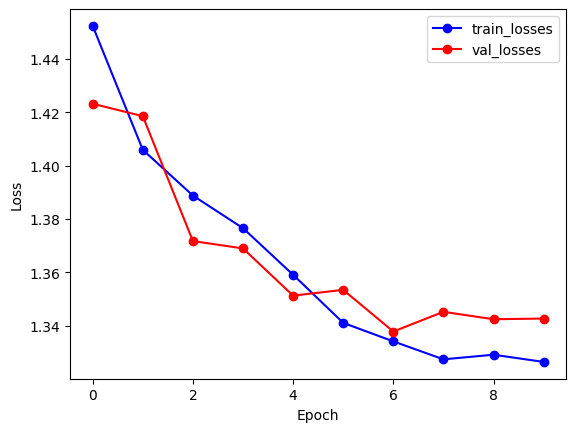

In [ ]:
# -- loss --
import matplotlib.pyplot as plt

plt.figure()
epoch = range(10)
plt.plot(epoch, train_losses,'-bo', label='train_losses')
plt.plot(epoch, val_losses, '-ro', label='val_losses')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss');
plt.show()

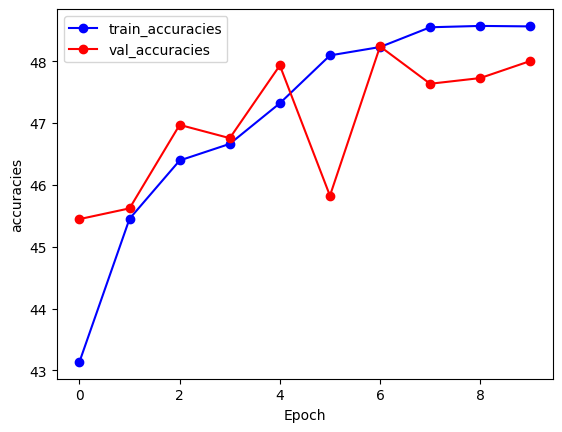

In [ ]:
# -- accuracy --
import matplotlib.pyplot as plt

plt.figure()
epoch = range(10)
plt.plot(epoch, train_accuracies,'-bo', label='train_accuracies')
plt.plot(epoch, val_accuracies, '-ro', label='val_accuracies')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('accuracies');

# only MobileNet2 model

In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [ ]:
# -- 필요한 데이터 --
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/revised_bungae_df.csv')
df['product_id'] = df['product_id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df['main_cat'] = df['main_cat'].astype(str)
df['mid_cat'] = df['mid_cat'].astype(str)
df.head()

,product_id,product_name,image_url,image_cnt,cat_id,main_cat,mid_cat
0,217365207,경량롱패딩,https://media.bunjang.co.kr/product/217365207_...,3.0,310090050,310,310090
1,175507846,롱패딩 판매합니다,https://media.bunjang.co.kr/product/175507846_...,4.0,310090050,310,310090
2,213094512,피레넥스 여성 화이트 패딩 55판-69,https://media.bunjang.co.kr/product/213094512_...,10.0,310090050,310,310090
3,208884568,보브 다운패딩,https://media.bunjang.co.kr/product/208884568_...,2.0,310090050,310,310090
4,164395818,에이글 코트타입 구스 자켓 L사이즈,https://media.bunjang.co.kr/product/164395818_...,5.0,310090050,310,310090


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

# Custom Dataset
class MultiModalDataset(Dataset):
    def __init__(self, image_data, labels, transform):
        self.image_data = image_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image = Image.open(self.image_data[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]  # Use labels directly without iloc

        return image, label


In [ ]:
# Split data into train, validation, and test sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.3, random_state=42)

image_train_data = []
image_val_data = []
image_test_data = []
for idx in range(len(df)):
    cat_id = df.loc[idx, 'cat_id']  # 소분류
    prd_id = df.loc[idx, 'product_id']
    # -- Adjust image_path based on category classification --
    image_path = f'/content/drive/MyDrive/bungae_image_folder_for_revised_df/{cat_id}/{prd_id}_image.jpg'
    if idx in train_data.index:
        image_train_data.append(image_path)
    elif idx in val_data.index:
        image_val_data.append(image_path)
    else:
        image_test_data.append(image_path)

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['cat_id'])
labels_train = df.loc[train_data.index, 'label'].tolist()  # Convert labels to list
labels_val = df.loc[val_data.index, 'label'].tolist()
labels_test = df.loc[test_data.index, 'label'].tolist()

# Define transformations for image data
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the custom datasets
train_dataset = MultiModalDataset(image_train_data, labels_train, image_transform)
val_dataset = MultiModalDataset(image_val_data, labels_val, image_transform)
test_dataset = MultiModalDataset(image_test_data, labels_test, image_transform)

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)  # Increase num_workers for parallel data loading
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Define the multi-modal model
class MultiModalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalModel, self).__init__()

        # Image Model (MobileNetV2)
        self.image_model = mobilenet_v2(pretrained=True)
        self.image_model.classifier = nn.Identity()  # Remove the final fully connected layer

        # Output Layer
        self.output_layer = nn.Linear(self.image_model.last_channel, num_classes)

    def forward(self, image_inputs):
        # Image Encoding
        image_outputs = self.image_model.features(image_inputs)
        image_outputs = torch.nn.functional.adaptive_avg_pool2d(image_outputs, 1).reshape(image_outputs.size(0), -1)

        # Output
        logits = self.output_layer(image_outputs)

        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [ ]:
# Initialize the multi-modal model
num_classes = df['cat_id'].nunique()
model = MultiModalModel(num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

model = model.to(device)
criterion = criterion.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)  # Send labels to the device

        optimizer.zero_grad()

        try:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        except Exception as e:
            print(f"Error during training: {e}")
            continue

    train_loss /= train_total

    train_accuracy = 100.0 * train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)  # Send labels to the device

            try:
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

            except Exception as e:
                print(f"Error during validation: {e}")
                continue

    val_loss /= val_total

    val_accuracy = 100.0 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the loss and accuracy for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


In [ ]:
# -- 학습 속도 개선할 수 있도록 해보기 --

In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [ ]:
# -- 필요한 데이터 --
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/revised_bungae_df.csv')
df['product_id'] = df['product_id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df['main_cat'] = df['main_cat'].astype(str)
df['mid_cat'] = df['mid_cat'].astype(str)
df.head()

,product_id,product_name,image_url,image_cnt,cat_id,main_cat,mid_cat
0,217365207,경량롱패딩,https://media.bunjang.co.kr/product/217365207_...,3.0,310090050,310,310090
1,175507846,롱패딩 판매합니다,https://media.bunjang.co.kr/product/175507846_...,4.0,310090050,310,310090
2,213094512,피레넥스 여성 화이트 패딩 55판-69,https://media.bunjang.co.kr/product/213094512_...,10.0,310090050,310,310090
3,208884568,보브 다운패딩,https://media.bunjang.co.kr/product/208884568_...,2.0,310090050,310,310090
4,164395818,에이글 코트타입 구스 자켓 L사이즈,https://media.bunjang.co.kr/product/164395818_...,5.0,310090050,310,310090


In [ ]:
from sklearn.model_selection import train_test_split
from torchvision.models import mobilenet_v2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm

# Split data into train, validation, and test sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.3, random_state=42)

# Define data directory
data_dir = '/content/drive/MyDrive/bungae_image_folder_for_revised_df/'

# Define transformations for image data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the train, validation, and test datasets
train_dataset = ImageFolder(root=data_dir + 'train', transform=data_transforms['train'])
val_dataset = ImageFolder(root=data_dir + 'val', transform=data_transforms['val'])
test_dataset = ImageFolder(root=data_dir + 'test', transform=data_transforms['val'])

# Define data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)  # Increase num_workers for parallel data loading
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the multi-modal model
class MultiModalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalModel, self).__init__()

        # Image Model (MobileNetV2)
        self.image_model = mobilenet_v2(pretrained=True)
        self.image_model.classifier = nn.Identity()  # Remove the final fully connected layer

        # Output Layer
        self.output_layer = nn.Linear(self.image_model.last_channel, num_classes)

    def forward(self, image_inputs):
        # Image Encoding
        image_outputs = self.image_model.features(image_inputs)
        image_outputs = torch.nn.functional.adaptive_avg_pool2d(image_outputs, 1).reshape(image_outputs.size(0), -1)

        # Output
        logits = self.output_layer(image_outputs)

        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the multi-modal model
num_classes = len(train_dataset.classes)
model = MultiModalModel(num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

model = model.to(device)
criterion = criterion.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(num_epochs)):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)  # Send labels to the device

        optimizer.zero_grad()

        try:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        except Exception as e:
            print(f"Error during training: {e}")
            continue

    train_loss /= train_total

    train_accuracy = 100.0 * train_correct / train_total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)  # Send labels to the device

            try:
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

            except Exception as e:
                print(f"Error during validation: {e}")
                continue

    val_loss /= val_total

    val_accuracy = 100.0 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the loss and accuracy for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


# 이미지 폴더 형태 바꾸기

In [ ]:
# -- 이미지 폴더 형태 바꾸기 --


In [ ]:
# -- 테스트 이미지 폴더 --
import os
ttvs = ['train', 'test', 'val']
for ttv in ttvs:
    os.makedirs('/content/drive/MyDrive/test_image_folder/' + ttv)


In [ ]:
# -- 데이터 스플릿 --
import pandas as pd
from sklearn.model_selection import train_test_split

def bring_df():
    df = pd.read_csv('/content/drive/MyDrive/revised_bungae_df.csv')
    # df['product_id'] = df['product_id'].astype(str)
    # df['cat_id'] = df['cat_id'].astype(str)
    df['main_cat'] = df['main_cat'].astype(str)
    df['mid_cat'] = df['mid_cat'].astype(str)
    return df

df = bring_df()

# Split data into train, validation, and test sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.3, random_state=42)


In [ ]:
train_data.sort_values(by=['cat_id', 'product_id'])

,product_id,product_name,image_url,image_cnt,cat_id,main_cat,mid_cat
23755,7626579,[55] 가디건볼레로,https://media.bunjang.co.kr/product/7626579_{c...,1.0,310070,310,310070
23702,76205447,[FREE] 레이스 가디건,https://media.bunjang.co.kr/product/76205447_{...,5.0,310070,310,310070
23814,81880183,NBA 정품 시스루 자켓? 가디건,https://media.bunjang.co.kr/product/81880183_{...,5.0,310070,310,310070
23561,89787538,라코스테 스트라이프 니트 가디건 38사이즈,https://media.bunjang.co.kr/product/89787538_{...,3.0,310070,310,310070
23734,107928169,골지가디건세트 free,https://media.bunjang.co.kr/product/107928169_...,2.0,310070,310,310070
...,...,...,...,...,...,...,...
81019,224964144,아르켓 트래블 백(72 아워 3 웨이 더플백),https://media.bunjang.co.kr/product/224964144_...,5.0,430300999,430,430300
80522,225277346,버버리 프로섬 13AW 런웨이 보스턴백,https://media.bunjang.co.kr/product/225277346_...,6.0,430300999,430,430300
80911,225283753,"검정가방숄더끈2개/갈색가방어께끈 노트북가방,사무용가방,여행용숄더백등총3개",https://media.bunjang.co.kr/product/225283753_...,5.0,430300999,430,430300
80868,225297070,루이비통 키폴 55,https://media.bunjang.co.kr/product/225297070_...,1.0,430300999,430,430300
